In [1]:
import os
import pandas as pd

In [2]:
df = pd.read_csv('/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/df_final_with_genres.csv')

In [3]:
df

,user_id,book_id,rating,decade,original_title,authors,genres
0,1,258,5,2000,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves","Mystery, Historical"
1,2,4081,4,2000,NaN,NaN,NaN
2,2,260,5,1930,How to Win Friends and Influence People,Dale Carnegie,"Nonfiction, Drama"
3,2,9296,5,1970,Das Drama des begabten Kindes und die Suche na...,"Alice Miller, Ruth Ward","Horror, Mystery"
4,2,2318,3,1990,The Millionaire Next Door: The Surprising Secr...,"Thomas J. Stanley, William D. Danko","Nonfiction, Drama"
...,...,...,...,...,...,...,...
5976474,49925,510,5,1990,The Great Hunt,Robert Jordan,"Fantasy, Adventure"
5976475,49925,528,4,1990,The Dragon Reborn,Robert Jordan,"Classics, Drama"
5976476,49925,722,4,1990,The Shadow Rising,Robert Jordan,"Adventure, Drama"
5976477,49925,949,5,1990,The Fires of Heaven,Robert Jordan,"Fantasy, Adventure"


## data analysis

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# --- Your canonical 13 genres, fixed order for rows/cols ---
GENRES_13 = [
    "Adult", "Adventure", "Children's", "Classics", "Drama",
    "Fantasy", "Historical", "Horror", "Mystery", "Nonfiction",
    "Romance", "Science Fiction", "Thriller"
]

def parse_genres(s):
    if pd.isna(s):
        return []
    return [g.strip() for g in str(s).split(",") if g.strip()]

def to_canonical_set(gstr):
    glist = [g for g in parse_genres(gstr) if g in GENRES_13]
    # de-duplicate while preserving first-seen order
    return list(dict.fromkeys(glist))

def analyze_ordered_cooccurrence(df):
    """
    Build an ORDER-SENSITIVE co-occurrence matrix (Gi -> Gj), Gi != Gj only
    """
    print("=== ORDERED CO-OCCURRENCE ANALYSIS ===")
    
    # 1) Collapse to UNIQUE books and keep one ordered genre list per book
    books = (
        df[['book_id', 'genres']]
          .dropna(subset=['book_id'])
          .sort_values('book_id')
          .drop_duplicates(subset=['book_id'], keep='first')
          .copy()
    )
    
    # Parse + filter to canonical 13, preserving order within each book
    books['genre_list'] = books['genres'].apply(parse_genres).apply(
        lambda gl: [g for g in gl if g in GENRES_13]
    )
    books = books[books['genre_list'].map(len) > 0].copy()
    
    # 2) Count and print how many UNIQUE canonical genres are actually present in df
    present = []
    for gl in books['genre_list']:
        present.extend(gl)
    present = sorted(set(present), key=lambda g: GENRES_13.index(g))
    
    print(f"Unique genres present (from canonical 13): {len(present)} / 13")
    print(present)
    
    # 3) Build an ORDER-SENSITIVE co-occurrence matrix (Gi -> Gj), Gi != Gj only
    idx = {g: i for i, g in enumerate(GENRES_13)}
    n = len(GENRES_13)
    co_mat = np.zeros((n, n), dtype=int)
    
    for gl in books['genre_list']:
        # First occurrence positions per genre in this book (preserve order)
        pos = {}
        for k, g in enumerate(gl):
            if g not in pos:
                pos[g] = k
        
        # Count ordered pairs where Gi occurs BEFORE Gj (Gi != Gj). No diagonal.
        genres_in_book = list(pos.keys())
        for gi in genres_in_book:
            for gj in genres_in_book:
                if gi == gj:
                    continue
                if pos[gi] < pos[gj]:
                    co_mat[idx[gi], idx[gj]] += 1
    
    # Wrap into a 13x13 DataFrame with fixed order (diagonal is guaranteed 0)
    co_df = pd.DataFrame(co_mat, index=GENRES_13, columns=GENRES_13)
    
    print("Ordered Co-occurrence Matrix:")
    print(co_df)
    return co_df

def analyze_symmetric_cooccurrence(df):
    """
    Build a SYMMETRIC co-occurrence matrix over UNIQUE books
    """
    print("\n=== SYMMETRIC CO-OCCURRENCE ANALYSIS ===")
    
    # 1) Collapse to UNIQUE books; keep one genres string per book_id
    books = (
        df[['book_id', 'genres']]
          .dropna(subset=['book_id'])
          .sort_values('book_id')
          .drop_duplicates(subset=['book_id'], keep='first')
          .copy()
    )
    
    # 2) Parse & filter to canonical 13; also de-duplicate within a book
    books['genre_list'] = books['genres'].apply(to_canonical_set)
    books = books[books['genre_list'].map(len) > 0].copy()
    
    # 3) Report how many of the canonical 13 actually appear
    present = sorted(set(g for gl in books['genre_list'] for g in gl), key=lambda g: GENRES_13.index(g))
    print(f"Unique genres present (from canonical 13): {len(present)} / 13")
    print(present)
    
    # 4) Build a SYMMETRIC co-occurrence matrix over UNIQUE books
    #    Cell (Gi, Gj) = number of UNIQUE books that contain BOTH Gi and Gj (order-agnostic)
    idx = {g: i for i, g in enumerate(GENRES_13)}
    n = len(GENRES_13)
    co_mat = np.zeros((n, n), dtype=int)
    
    for gl in books['genre_list']:
        s = list(set(gl))           # ensure uniqueness before making pairs
        for g1, g2 in combinations(s, 2):
            i, j = idx[g1], idx[g2]
            # increment both directions to enforce symmetry
            co_mat[i, j] += 1
            co_mat[j, i] += 1
    
    # Zero the diagonal (no GiGi counts)
    np.fill_diagonal(co_mat, 0)
    
    # 5) Wrap in DataFrame
    co_df = pd.DataFrame(co_mat, index=GENRES_13, columns=GENRES_13)
    
    print("Symmetric Co-occurrence Matrix:")
    print(co_df)
    return co_df

def main_analysis(df):
    """
    Run both analyses on the provided dataframe
    """
    print("Starting Genre Co-occurrence Analysis")
    print(f"Total rows in dataset: {len(df)}")
    
    # Run ordered analysis
    ordered_matrix = analyze_ordered_cooccurrence(df)
    
    # Run symmetric analysis  
    symmetric_matrix = analyze_symmetric_cooccurrence(df)
    
    # Optional: save results
    save_results = input("\nSave results to CSV? (y/n): ").lower() == 'y'
    if save_results:
        ordered_matrix.to_csv("ordered_genre_cooccurrence_unique_books_13x13.csv", index=True)
        symmetric_matrix.to_csv("symmetric_genre_cooccurrence_unique_books_13x13.csv", index=True)
        print("Results saved to CSV files.")
    
    return ordered_matrix, symmetric_matrix

# Example usage:
# Assuming you have a DataFrame called 'df' with columns 'book_id' and 'genres'
# ordered_result, symmetric_result = main_analysis(df)
main_analysis(df)

In [7]:
ordered_matrix = pd.read_csv("ordered_genre_cooccurrence_unique_books_13x13.csv")
ordered_matrix

,Unnamed: 0,Adult,Adventure,Children's,Classics,Drama,Fantasy,Historical,Horror,Mystery,Nonfiction,Romance,Science Fiction,Thriller
0,Adult,0,0,0,4,91,0,2,0,3,6,0,0,0
1,Adventure,0,0,9,46,35,6,17,1,27,14,1,6,23
2,Children's,0,284,0,137,93,66,30,4,56,11,13,0,0
3,Classics,1,17,5,0,286,11,10,6,23,25,7,1,0
4,Drama,53,16,1,83,0,1,21,0,26,18,8,0,2
5,Fantasy,2,812,99,14,98,0,35,193,236,16,232,17,40
6,Historical,3,31,9,14,286,4,0,1,38,44,59,1,7
7,Horror,0,6,8,15,33,42,0,0,194,3,23,6,97
8,Mystery,5,45,11,37,246,14,67,38,0,3,50,0,799
9,Nonfiction,18,62,6,88,585,7,35,1,19,0,10,41,6


In [8]:
symmetric_matrix = pd.read_csv("symmetric_genre_cooccurrence_unique_books_13x13.csv")
symmetric_matrix

,Unnamed: 0,Adult,Adventure,Children's,Classics,Drama,Fantasy,Historical,Horror,Mystery,Nonfiction,Romance,Science Fiction,Thriller
0,Adult,0,0,0,5,144,2,5,0,8,24,139,0,4
1,Adventure,0,0,293,63,51,818,48,7,72,76,19,264,78
2,Children's,0,293,0,142,94,165,39,12,67,17,22,12,0
3,Classics,5,63,142,0,369,25,24,21,60,113,44,35,0
4,Drama,144,51,94,369,0,99,307,33,272,603,941,65,28
5,Fantasy,2,818,165,25,99,0,39,235,250,23,351,41,40
6,Historical,5,48,39,24,307,39,0,1,105,79,189,8,13
7,Horror,0,7,12,21,33,235,1,0,232,4,55,46,123
8,Mystery,8,72,67,60,272,250,105,232,0,22,257,130,1088
9,Nonfiction,24,76,17,113,603,23,79,4,22,0,30,69,11


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# --- Your canonical 13 genres, fixed order for rows/cols ---
GENRES_13 = [
    "Adult", "Adventure", "Children's", "Classics", "Drama",
    "Fantasy", "Historical", "Horror", "Mystery", "Nonfiction",
    "Romance", "Science Fiction", "Thriller"
]

def parse_genres(s):
    if pd.isna(s):
        return []
    return [g.strip() for g in str(s).split(",") if g.strip()]

def to_canonical_set(gstr):
    glist = [g for g in parse_genres(gstr) if g in GENRES_13]
    # de-duplicate while preserving first-seen order
    return list(dict.fromkeys(glist))

def analyze_ordered_cooccurrence(df):
    """
    Build an ORDER-SENSITIVE co-occurrence matrix (Gi -> Gj), Gi != Gj only
    """
    print("=== ORDERED CO-OCCURRENCE ANALYSIS ===")
    
    # 1) Collapse to UNIQUE books and keep one ordered genre list per book
    books = (
        df[['book_id', 'genres']]
          .dropna(subset=['book_id'])
          .sort_values('book_id')
          .drop_duplicates(subset=['book_id'], keep='first')
          .copy()
    )
    
    # Parse + filter to canonical 13, preserving order within each book
    books['genre_list'] = books['genres'].apply(parse_genres).apply(
        lambda gl: [g for g in gl if g in GENRES_13]
    )
    books = books[books['genre_list'].map(len) > 0].copy()
    
    # 2) Count and print how many UNIQUE canonical genres are actually present in df
    present = []
    for gl in books['genre_list']:
        present.extend(gl)
    present = sorted(set(present), key=lambda g: GENRES_13.index(g))
    
    print(f"Unique genres present (from canonical 13): {len(present)} / 13")
    print(present)
    
    # 3) Build an ORDER-SENSITIVE co-occurrence matrix (Gi -> Gj), Gi != Gj only
    idx = {g: i for i, g in enumerate(GENRES_13)}
    n = len(GENRES_13)
    co_mat = np.zeros((n, n), dtype=int)
    
    for gl in books['genre_list']:
        # First occurrence positions per genre in this book (preserve order)
        pos = {}
        for k, g in enumerate(gl):
            if g not in pos:
                pos[g] = k
        
        # Count ordered pairs where Gi occurs BEFORE Gj (Gi != Gj). No diagonal.
        genres_in_book = list(pos.keys())
        for gi in genres_in_book:
            for gj in genres_in_book:
                if gi == gj:
                    continue
                if pos[gi] < pos[gj]:
                    co_mat[idx[gi], idx[gj]] += 1
    
    # Wrap into a 13x13 DataFrame with fixed order (diagonal is guaranteed 0)
    co_df = pd.DataFrame(co_mat, index=GENRES_13, columns=GENRES_13)
    
    print("Ordered Co-occurrence Matrix:")
    print(co_df)
    return co_df

def analyze_symmetric_cooccurrence(df):
    """
    Build a SYMMETRIC co-occurrence matrix over UNIQUE books
    """
    print("\n=== SYMMETRIC CO-OCCURRENCE ANALYSIS ===")
    
    # 1) Collapse to UNIQUE books; keep one genres string per book_id
    books = (
        df[['book_id', 'genres']]
          .dropna(subset=['book_id'])
          .sort_values('book_id')
          .drop_duplicates(subset=['book_id'], keep='first')
          .copy()
    )
    
    # 2) Parse & filter to canonical 13; also de-duplicate within a book
    books['genre_list'] = books['genres'].apply(to_canonical_set)
    books = books[books['genre_list'].map(len) > 0].copy()
    
    # 3) Report how many of the canonical 13 actually appear
    present = sorted(set(g for gl in books['genre_list'] for g in gl), key=lambda g: GENRES_13.index(g))
    print(f"Unique genres present (from canonical 13): {len(present)} / 13")
    print(present)
    
    # 4) Build a SYMMETRIC co-occurrence matrix over UNIQUE books
    #    Cell (Gi, Gj) = number of UNIQUE books that contain BOTH Gi and Gj (order-agnostic)
    idx = {g: i for i, g in enumerate(GENRES_13)}
    n = len(GENRES_13)
    co_mat = np.zeros((n, n), dtype=int)
    
    for gl in books['genre_list']:
        s = list(set(gl))           # ensure uniqueness before making pairs
        for g1, g2 in combinations(s, 2):
            i, j = idx[g1], idx[g2]
            # increment both directions to enforce symmetry
            co_mat[i, j] += 1
            co_mat[j, i] += 1
    
    # Zero the diagonal (no GiGi counts)
    np.fill_diagonal(co_mat, 0)
    
    # 5) Wrap in DataFrame
    co_df = pd.DataFrame(co_mat, index=GENRES_13, columns=GENRES_13)
    
    print("Symmetric Co-occurrence Matrix:")
    print(co_df)
    return co_df

def main_analysis(df):
    """
    Run both analyses on the provided dataframe
    """
    print("Starting Genre Co-occurrence Analysis")
    print(f"Total rows in dataset: {len(df)}")
    
    # Run ordered analysis
    ordered_matrix = analyze_ordered_cooccurrence(df)
    
    # Run symmetric analysis  
    symmetric_matrix = analyze_symmetric_cooccurrence(df)
    
    # Optional: save results
    save_results = input("\nSave results to CSV? (y/n): ").lower() == 'y'
    if save_results:
        ordered_matrix.to_csv("ordered_genre_cooccurrence_unique_books_13x13.csv", index=True)
        symmetric_matrix.to_csv("symmetric_genre_cooccurrence_unique_books_13x13.csv", index=True)
        print("Results saved to CSV files.")
    
    return ordered_matrix, symmetric_matrix

def analyze_genre_pairs(df):
    """
    Build a detailed pairwise analysis table and print formatted output
    """
    print("\n=== GENRE PAIR ANALYSIS ===")
    
    # 1) Unique books with ordered genre lists
    books = (
        df[['book_id', 'genres']]
          .dropna(subset=['book_id'])
          .drop_duplicates(subset=['book_id'], keep='first')
          .copy()
    )
    books['genre_list'] = books['genres'].apply(parse_genres)
    books = books[books['genre_list'].map(len) > 0].copy()
    
    # 2) Discover all genres from the dataset
    GENRES = sorted({g for gl in books['genre_list'] for g in gl})
    print(f"Total unique genres found: {len(GENRES)}")
    
    # 3) Build a per-book position map for quick order comparisons
    pos_maps = []
    for gl in books['genre_list']:
        pos = {}
        for idx, g in enumerate(gl):
            if g not in pos:
                pos[g] = idx
        pos_maps.append(pos)
    
    # 4) Count for every pair
    def count_pair(g1, g2):
        total_both = 0
        g1_before_g2 = 0
        g2_before_g1 = 0
        for pos in pos_maps:
            if g1 in pos and g2 in pos:
                total_both += 1
                if pos[g1] < pos[g2]:
                    g1_before_g2 += 1
                elif pos[g2] < pos[g1]:
                    g2_before_g1 += 1
        return total_both, g1_before_g2, g2_before_g1
    
    # 5) Build tidy table and print formatted output
    rows = []
    print("\nDetailed pair analysis:")
    for i, g1 in enumerate(GENRES):
        for j in range(i+1, len(GENRES)):
            g2 = GENRES[j]
            total_both, g1_before_g2, g2_before_g1 = count_pair(g1, g2)
            
            # Print in requested format
            print(f"Total books in {g1}, {g2}: {total_both}")
            print(f"{g1.lower()}, {g2.lower()}: {g1_before_g2}")
            print(f"{g2.lower()}, {g1.lower()}: {g2_before_g1}")
            
            # Add to table
            rows.append({
                "Genre 1": g1,
                "Genre 2": g2,
                "Total Books (both)": total_both,
                "G1→G2 (g1 before g2)": g1_before_g2,
                "G2→G1 (g2 before g1)": g2_before_g1
            })
    
    # Create DataFrame
    pair_df = pd.DataFrame(rows).sort_values(["Genre 1", "Genre 2"]).reset_index(drop=True)
    
    # Add rates
    pair_df["G1→G2 rate"] = pair_df.apply(
        lambda r: (r["G1→G2 (g1 before g2)"] / r["Total Books (both)"]) if r["Total Books (both)"] else 0.0, axis=1
    )
    pair_df["G2→G1 rate"] = pair_df.apply(
        lambda r: (r["G2→G1 (g2 before g1)"] / r["Total Books (both)"]) if r["Total Books (both)"] else 0.0, axis=1
    )
    
    print("\nPair analysis table:")
    print(pair_df.to_string(index=False))
    
    # Build matrices
    all_genres = GENRES
    sym_totals = pd.DataFrame(0, index=all_genres, columns=all_genres, dtype=int)
    for _, r in pair_df.iterrows():
        g1, g2, t = r["Genre 1"], r["Genre 2"], int(r["Total Books (both)"])
        sym_totals.loc[g1, g2] = t
        sym_totals.loc[g2, g1] = t
    
    return pair_df, sym_totals

def main_analysis_extended(df):
    """
    Run all three analyses on the provided dataframe
    """
    print("Starting Extended Genre Co-occurrence Analysis")
    print(f"Total rows in dataset: {len(df)}")
    
    # Run ordered analysis
    ordered_matrix = analyze_ordered_cooccurrence(df)
    
    # Run symmetric analysis  
    symmetric_matrix = analyze_symmetric_cooccurrence(df)
    
    # Run pair analysis
    pair_df, pair_matrix = analyze_genre_pairs(df)
    
    # Optional: save results
    save_results = input("\nSave results to CSV? (y/n): ").lower() == 'y'
    if save_results:
        ordered_matrix.to_csv("ordered_genre_cooccurrence_unique_books_13x13.csv", index=True)
        symmetric_matrix.to_csv("symmetric_genre_cooccurrence_unique_books_13x13.csv", index=True)
        pair_df.to_csv("genre_pair_order_table.csv", index=False)
        pair_matrix.to_csv("genre_pair_totals_symmetric.csv", index=True)
        print("Results saved to CSV files.")
    
    return ordered_matrix, symmetric_matrix, pair_df, pair_matrix

# Example usage:
# Assuming you have a DataFrame called 'df' with columns 'book_id' and 'genres'
# ordered_result, symmetric_result, pair_result, pair_matrix = main_analysis_extended(df)
main_analysis_extended(df)

In [13]:
pair_df =  pd.read_csv("genre_pair_order_table.csv")
pair_df

,Genre 1,Genre 2,Total Books (both),G1→G2 (g1 before g2),G2→G1 (g2 before g1),G1→G2 rate,G2→G1 rate
0,Adult,Adventure,0,0,0,0.000000,0.000000
1,Adult,Children's,0,0,0,0.000000,0.000000
2,Adult,Classics,5,4,1,0.800000,0.200000
3,Adult,Drama,144,91,53,0.631944,0.368056
4,Adult,Fantasy,2,0,2,0.000000,1.000000
...,...,...,...,...,...,...,...
73,Nonfiction,Science Fiction,69,41,28,0.594203,0.405797
74,Nonfiction,Thriller,11,6,5,0.545455,0.454545
75,Romance,Science Fiction,24,2,22,0.083333,0.916667
76,Romance,Thriller,60,58,2,0.966667,0.033333


In [14]:
pair_matrix = pd.read_csv("genre_pair_totals_symmetric.csv")
pair_matrix

,Unnamed: 0,Adult,Adventure,Children's,Classics,Drama,Fantasy,Historical,Horror,Mystery,Nonfiction,Romance,Science Fiction,Thriller
0,Adult,0,0,0,5,144,2,5,0,8,24,139,0,4
1,Adventure,0,0,293,63,51,818,48,7,72,76,19,264,78
2,Children's,0,293,0,142,94,165,39,12,67,17,22,12,0
3,Classics,5,63,142,0,369,25,24,21,60,113,44,35,0
4,Drama,144,51,94,369,0,99,307,33,272,603,941,65,28
5,Fantasy,2,818,165,25,99,0,39,235,250,23,351,41,40
6,Historical,5,48,39,24,307,39,0,1,105,79,189,8,13
7,Horror,0,7,12,21,33,235,1,0,232,4,55,46,123
8,Mystery,8,72,67,60,272,250,105,232,0,22,257,130,1088
9,Nonfiction,24,76,17,113,603,23,79,4,22,0,30,69,11


In [12]:
ordered_matrix = pd.read_csv("ordered_genre_cooccurrence_unique_books_13x13.csv")
ordered_matrix 


,Unnamed: 0,Adult,Adventure,Children's,Classics,Drama,Fantasy,Historical,Horror,Mystery,Nonfiction,Romance,Science Fiction,Thriller
0,Adult,0,0,0,4,91,0,2,0,3,6,0,0,0
1,Adventure,0,0,9,46,35,6,17,1,27,14,1,6,23
2,Children's,0,284,0,137,93,66,30,4,56,11,13,0,0
3,Classics,1,17,5,0,286,11,10,6,23,25,7,1,0
4,Drama,53,16,1,83,0,1,21,0,26,18,8,0,2
5,Fantasy,2,812,99,14,98,0,35,193,236,16,232,17,40
6,Historical,3,31,9,14,286,4,0,1,38,44,59,1,7
7,Horror,0,6,8,15,33,42,0,0,194,3,23,6,97
8,Mystery,5,45,11,37,246,14,67,38,0,3,50,0,799
9,Nonfiction,18,62,6,88,585,7,35,1,19,0,10,41,6


In [ ]:
symmetric_matrix = pd.read_csv("symmetric_genre_cooccurrence_unique_books_13x13.csv")
symmetric_matrix 

,Unnamed: 0,Adult,Adventure,Children's,Classics,Drama,Fantasy,Historical,Horror,Mystery,Nonfiction,Romance,Science Fiction,Thriller
0,Adult,0,0,0,5,144,2,5,0,8,24,139,0,4
1,Adventure,0,0,293,63,51,818,48,7,72,76,19,264,78
2,Children's,0,293,0,142,94,165,39,12,67,17,22,12,0
3,Classics,5,63,142,0,369,25,24,21,60,113,44,35,0
4,Drama,144,51,94,369,0,99,307,33,272,603,941,65,28
5,Fantasy,2,818,165,25,99,0,39,235,250,23,351,41,40
6,Historical,5,48,39,24,307,39,0,1,105,79,189,8,13
7,Horror,0,7,12,21,33,235,1,0,232,4,55,46,123
8,Mystery,8,72,67,60,272,250,105,232,0,22,257,130,1088
9,Nonfiction,24,76,17,113,603,23,79,4,22,0,30,69,11


In [13]:
import re
import pandas as pd

# collapse to unique books
books_raw = (
    df[['book_id', 'original_title', 'authors', 'genres']]
      .dropna(subset=['book_id'])
      .sort_values('book_id')
      .drop_duplicates(subset=['book_id'], keep='first')
      .copy()
)

def split_genres(s):
    if pd.isna(s):
        return []
    return [g.strip() for g in str(s).split(",") if g.strip()]

tmp = books_raw.dropna(subset=['genres']).copy()
tmp['genre_list_raw'] = tmp['genres'].apply(split_genres)

def has_both(gl, a, b):
    s = set(gl)
    return a in s and b in s

pair = ("Adventure", "Fantasy")
mask_pair = tmp['genre_list_raw'].apply(lambda gl: has_both(gl, *pair))
subset = tmp[mask_pair]

print(f"Books with BOTH {pair[0]} and {pair[1]}:", len(subset))
display(subset[['book_id','original_title','authors','genres']].head(20))


Books with BOTH Adventure and Fantasy: 818


,book_id,original_title,authors,genres
3246005,6,The Fault in Our Stars,John Green,"Fantasy, Adventure"
1635898,19,The Fellowship of the Ring,J.R.R. Tolkien,"Fantasy, Adventure"
123194,21,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré","Fantasy, Adventure"
3940906,23,Harry Potter and the Chamber of Secrets,"J.K. Rowling, Mary GrandPré","Fantasy, Adventure"
2917592,24,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré","Fantasy, Adventure"
2740016,25,Harry Potter and the Deathly Hallows,"J.K. Rowling, Mary GrandPré","Fantasy, Adventure"
3034951,27,Harry Potter and the Half-Blood Prince,"J.K. Rowling, Mary GrandPré","Fantasy, Adventure"
3679511,36,The Giver,Lois Lowry,"Fantasy, Adventure"
576279,38,The Time Traveler's Wife,Audrey Niffenegger,"Fantasy, Adventure"
427492,41,The Lightning Thief,Rick Riordan,"Fantasy, Adventure"


In [25]:
import pandas as pd
import numpy as np

# Load the matrices
symmetric_matrix = pd.read_csv("symmetric_genre_cooccurrence_unique_books_13x13.csv", index_col=0)
ordered_matrix = pd.read_csv("ordered_genre_cooccurrence_unique_books_13x13.csv", index_col=0)

# Count total possible genre pairs
total_genres = len(symmetric_matrix.columns)
total_possible_pairs = (total_genres * (total_genres - 1)) // 2  # C(n,2)
print(f"Total genres: {total_genres}")
print(f"Total possible genre pairs: {total_possible_pairs}")

# Count non-zero pairs in upper triangle only (to avoid double counting)
upper_triangle = np.triu(symmetric_matrix.values, k=1)  # Upper triangle excluding diagonal
non_zero_pairs = np.count_nonzero(upper_triangle)
zero_pairs = total_possible_pairs - non_zero_pairs

print(f"Non-zero genre pairs: {non_zero_pairs}")
print(f"Zero genre pairs: {zero_pairs}")

# Count zeros in full matrices
symmetric_zeros = (symmetric_matrix == 0).sum().sum()
ordered_zeros = (ordered_matrix == 0).sum().sum()
print(f"Total zeros in symmetric matrix: {symmetric_zeros}")
print(f"Total zeros in ordered matrix: {ordered_zeros}")

# Show pairs that never co-occur
print(f"\n=== PAIRS THAT NEVER CO-OCCUR ({zero_pairs} pairs) ===")
genres = ordered_matrix.index.tolist()
never_cooccur = []

for i in range(len(genres)):
    for j in range(i+1, len(genres)):
        g1, g2 = genres[i], genres[j]
        total = symmetric_matrix.loc[g1, g2]
        if total == 0:
            never_cooccur.append(f"{g1} - {g2}")
            print(f"{g1} - {g2}")

# Show ALL genre pairs with their directional counts
print(f"\n=== ALL GENRE PAIRS (78 total) ===")

for i in range(len(genres)):
    for j in range(i+1, len(genres)):
        g1, g2 = genres[i], genres[j]
        g1_to_g2 = ordered_matrix.loc[g1, g2]
        g2_to_g1 = ordered_matrix.loc[g2, g1]
        total = symmetric_matrix.loc[g1, g2]
        
        if total == 0:
            print(f"{g1}-{g2}: NEVER CO-OCCUR")
        else:
            print(f"{g1}-{g2}: {g1}→{g2}={g1_to_g2}, {g2}→{g1}={g2_to_g1}, Total={total}")

print(f"\n=== SUMMARY ===")
print(f"Pairs that never co-occur: {zero_pairs}")
print(f"Never co-occur list: {', '.join(never_cooccur)}")
print(f"Pairs that co-occur: {non_zero_pairs}")
print(f"Total pairs: {total_possible_pairs}")

Total genres: 13
Total possible genre pairs: 78
Non-zero genre pairs: 72
Zero genre pairs: 6
Total zeros in symmetric matrix: 25
Total zeros in ordered matrix: 34

=== PAIRS THAT NEVER CO-OCCUR (6 pairs) ===
Adult - Adventure
Adult - Children's
Adult - Horror
Adult - Science Fiction
Children's - Thriller
Classics - Thriller

=== ALL GENRE PAIRS (78 total) ===
Adult-Adventure: NEVER CO-OCCUR
Adult-Children's: NEVER CO-OCCUR
Adult-Classics: Adult→Classics=4, Classics→Adult=1, Total=5
Adult-Drama: Adult→Drama=91, Drama→Adult=53, Total=144
Adult-Fantasy: Adult→Fantasy=0, Fantasy→Adult=2, Total=2
Adult-Historical: Adult→Historical=2, Historical→Adult=3, Total=5
Adult-Horror: NEVER CO-OCCUR
Adult-Mystery: Adult→Mystery=3, Mystery→Adult=5, Total=8
Adult-Nonfiction: Adult→Nonfiction=6, Nonfiction→Adult=18, Total=24
Adult-Romance: Adult→Romance=0, Romance→Adult=139, Total=139
Adult-Science Fiction: NEVER CO-OCCUR
Adult-Thriller: Adult→Thriller=0, Thriller→Adult=4, Total=4
Adventure-Children's: 

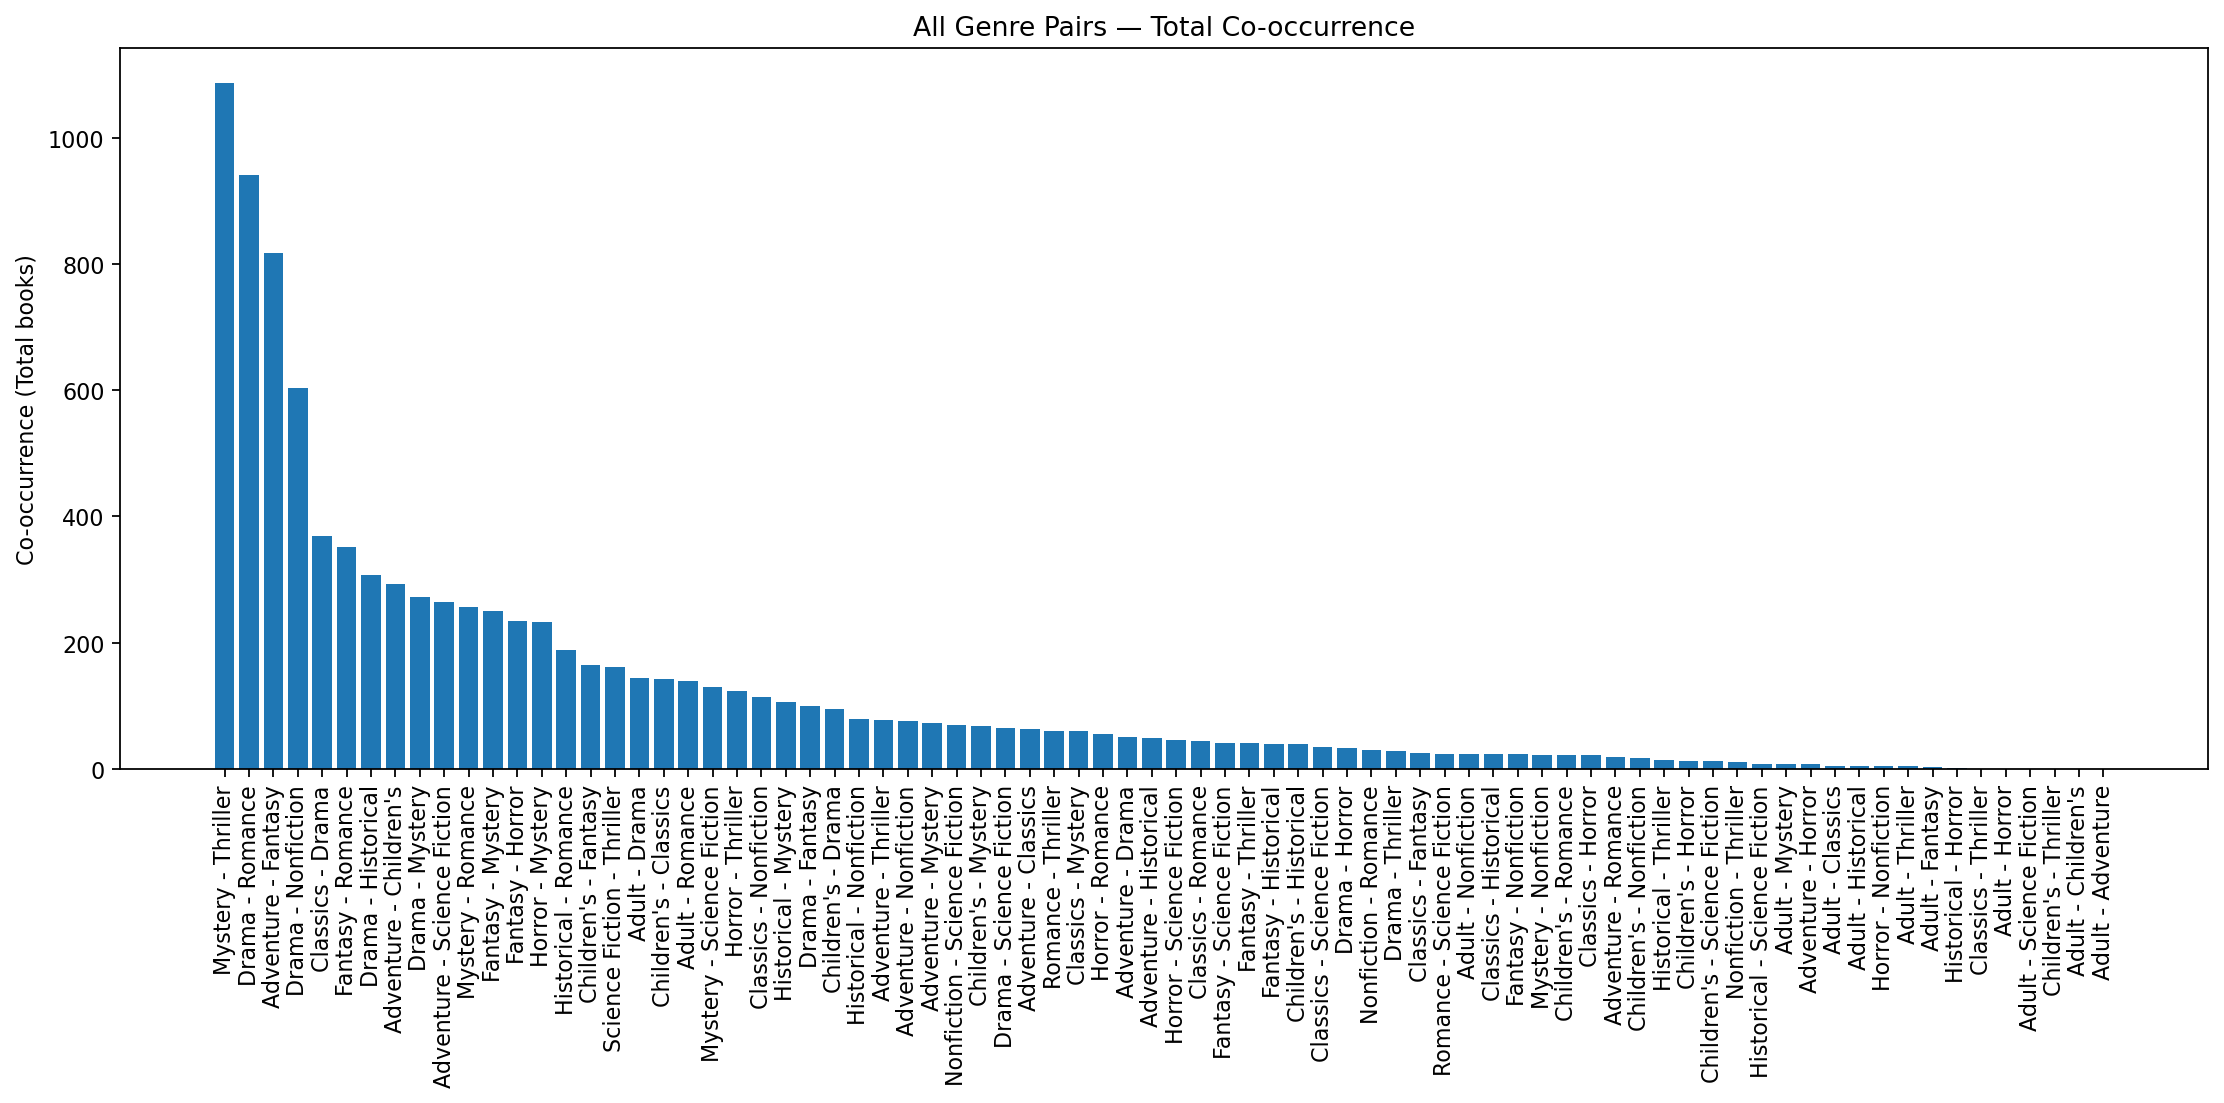

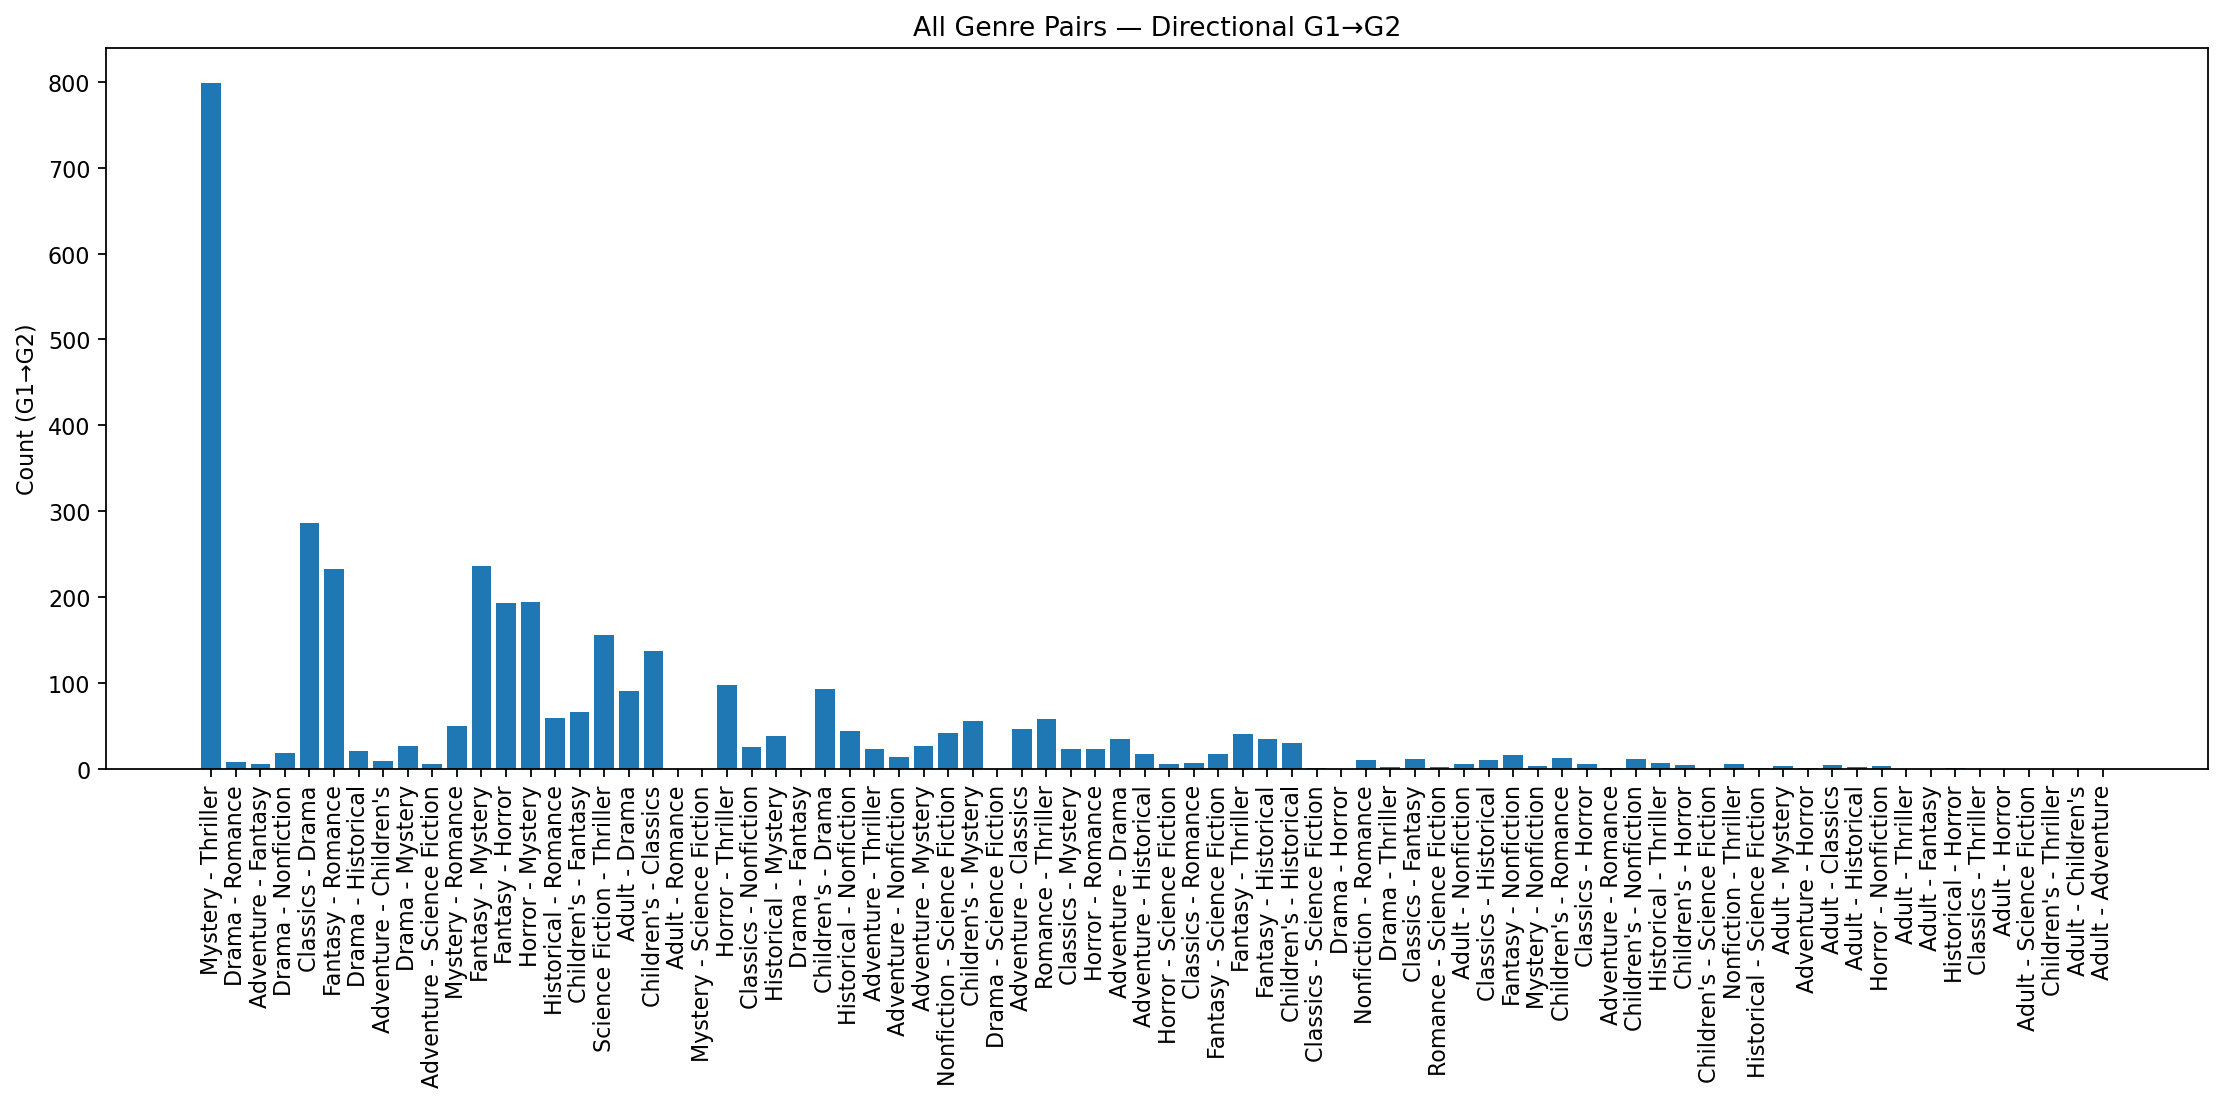

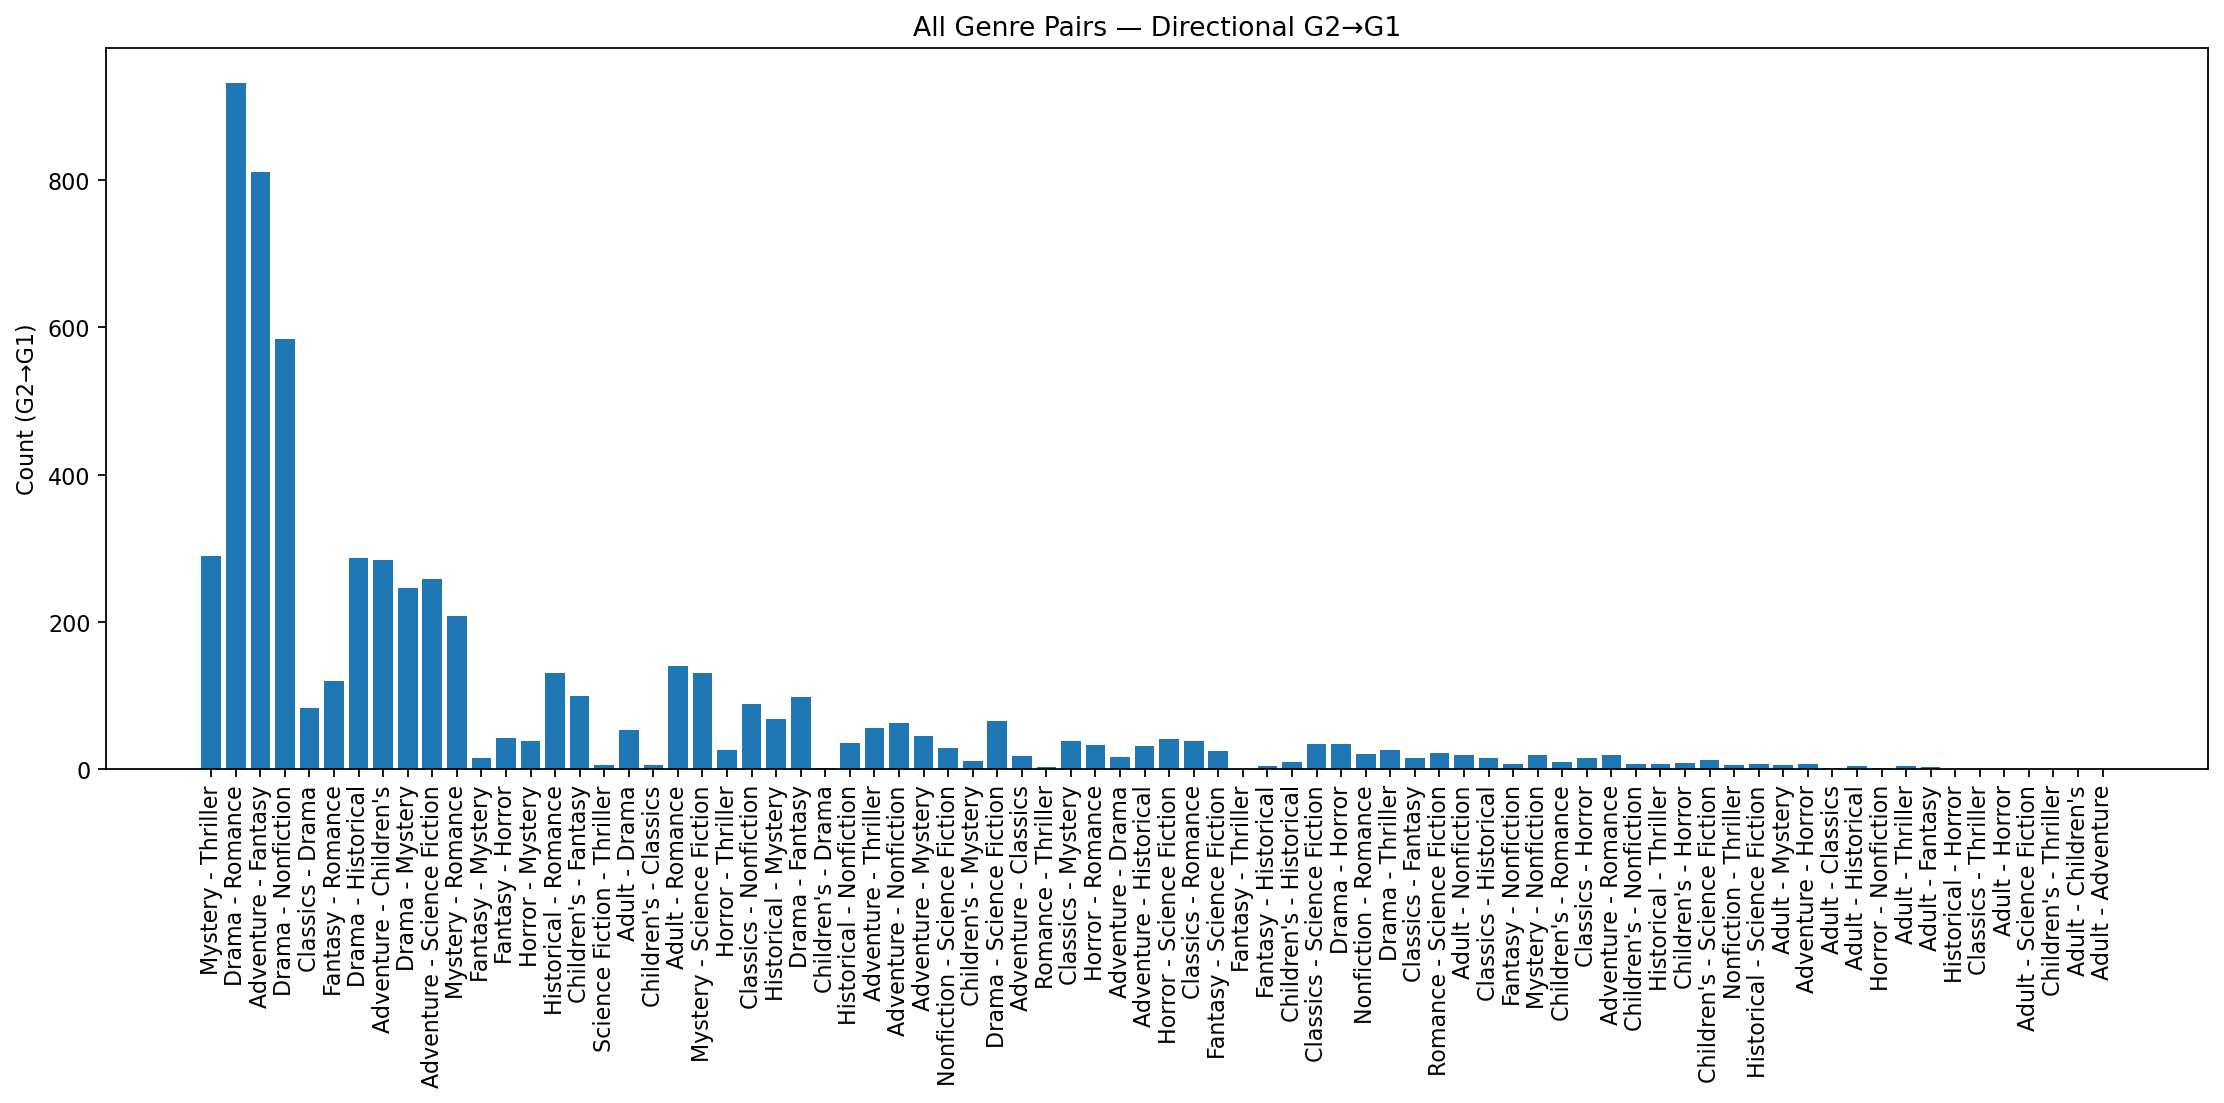

In [9]:
# plot_pairs_from_merge_outputs.py
# Reads the OUTPUT CSVs produced by merge_genre_pairs_viz.py and creates
# three bar charts:
#   1) Total co-occurrence per unordered pair (G1–G2)
#   2) Directional G1→G2 counts
#   3) Directional G2→G1 counts
# The script SHOWS the figures (no prints) and also saves them under
# genre_pair_merge_outputs/.

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Where the previous script saved its CSVs ----
OUTDIR = Path("genre_pair_merge_outputs")

# Prefer CSV-based matrices; fall back to Text-based if needed
sym_path = None
ord_path = None

cand_sym = [OUTDIR / "symmetric_from_csv.csv", OUTDIR / "symmetric_from_text.csv"]
cand_ord = [OUTDIR / "ordered_from_csv.csv", OUTDIR / "ordered_from_text.csv"]

for p in cand_sym:
    if p.exists():
        sym_path = p
        break
for p in cand_ord:
    if p.exists():
        ord_path = p
        break

if sym_path is None or ord_path is None:
    raise FileNotFoundError(
        "Required inputs not found. Run merge_genre_pairs_viz.py first to create "
        "'symmetric_from_*.csv' and 'ordered_from_*.csv' under genre_pair_merge_outputs/."
    )

# ---- Load matrices (indexes/columns are genre names) ----
sym = pd.read_csv(sym_path, index_col=0)
ordered = pd.read_csv(ord_path, index_col=0)

# Align and ensure int
genres = sorted(set(sym.index).intersection(sym.columns)
                .intersection(ordered.index).intersection(ordered.columns))
sym = sym.reindex(index=genres, columns=genres).fillna(0).astype(int)
ordered = ordered.reindex(index=genres, columns=genres).fillna(0).astype(int)
np.fill_diagonal(sym.values, 0)

# ---- Build pair table (unordered pairs only; keep both directions) ----
pairs = []
for i in range(len(genres)):
    for j in range(i+1, len(genres)):
        g1, g2 = genres[i], genres[j]
        total = int(sym.loc[g1, g2])
        g1g2 = int(ordered.loc[g1, g2])
        g2g1 = int(ordered.loc[g2, g1])
        pairs.append({"pair": f"{g1} - {g2}", "Total": total, "G1G2": g1g2, "G2G1": g2g1})

df = pd.DataFrame(pairs)

# Sort by Total descending so all three charts share the same order
df = df.sort_values("Total", ascending=False).reset_index(drop=True)

# ---- 1) Bar chart: Total per pair ----
fig1, ax1 = plt.subplots(figsize=(14, 7), dpi=160)
x = np.arange(len(df))
ax1.bar(x, df["Total"].to_numpy())
ax1.set_xticks(x)
ax1.set_xticklabels(df["pair"].tolist(), rotation=90)
ax1.set_ylabel("Co-occurrence (Total books)")
ax1.set_title("All Genre Pairs — Total Co-occurrence")
fig1.tight_layout()
fig1.savefig(OUTDIR / "bar_all_pairs_total.png")
plt.show()

# ---- 2) Bar chart: G1→G2 per pair (same order) ----
fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=160)
ax2.bar(x, df["G1G2"].to_numpy())
ax2.set_xticks(x)
ax2.set_xticklabels(df["pair"].tolist(), rotation=90)
ax2.set_ylabel("Count (G1→G2)")
ax2.set_title("All Genre Pairs — Directional G1→G2")
fig2.tight_layout()
fig2.savefig(OUTDIR / "bar_all_pairs_g1g2.png")
plt.show()

# ---- 3) Bar chart: G2→G1 per pair (same order) ----
fig3, ax3 = plt.subplots(figsize=(14, 7), dpi=160)
ax3.bar(x, df["G2G1"].to_numpy())
ax3.set_xticks(x)
ax3.set_xticklabels(df["pair"].tolist(), rotation=90)
ax3.set_ylabel("Count (G2→G1)")
ax3.set_title("All Genre Pairs — Directional G2→G1")
fig3.tight_layout()
fig3.savefig(OUTDIR / "bar_all_pairs_g2g1.png")
plt.show()


In [ ]:
git add .
git commit -m "pair"
git push